### Import Libraries

In [1]:
import os
import time
import pywt
import numpy as np
import pandas as pd
import livelossplot
import matplotlib.pyplot as plt
from numpy import newaxis
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Activation, Dropout, Input, LSTM
from keras.optimizers import Adam, RMSprop
from keras import backend as K

C:\Users\blee3\Anaconda2\envs\py36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Load Data

In [2]:
def load_data(data, seq_len, threshold):
    sequence_length = seq_len + 1
    result = []
    
    closing = data[:,3]
    direction_data = directional_data(threshold,closing,seq_len)
    direction_data = np.array(direction_data)
    
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length, :])

    result = np.array(result)
    original_data = result.copy()
    
    for index in range(result.shape[2]):
        result[:,:,index] = normalise_windows(result[:,:,index])

    row = round(0.9 * result.shape[0])
    train = result[:int(row), :, :]
    x_train = train[:, :-1, :]
    y_train = train[:, -1, 3]
    x_test = result[int(row):, :-1, :]
    y_test = result[int(row):, -1, 3]
    original_data = original_data[int(row):, :]
    direction_data = direction_data[int(row):]
    
    return [x_train, y_train, x_test, y_test, original_data, direction_data]

- Normalize the window of data

n = normalised list (window) of price changes

p = raw list (window) of adjusted daily return prices

Normalisation: ni = (pi/p0) - 1

De-Normalisation: pi = p0(ni + 1)

In [3]:
def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        if not window[0] == 0:
            normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        else:
            normalised_window = [float(p) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

In [4]:
# Mean Directional Accuracy
def mda(y_true, y_pred):
    s = K.equal(K.sign(y_true[1:] - y_true[:-1]),
                 K.sign(y_pred[1:] - y_pred[:-1]))
    return K.mean(K.cast(s, K.floatx()))

dependencies = {
     'mda': mda
}

In [5]:
def directional_data(threshold, data, seq_len):
    result = []
    sequence_length = seq_len + 1
    for j in range(len(data) - sequence_length):
        i = j + seq_len
        if abs(data[i]-data[i-1]) < threshold:
            result.append([0,1,0])
        elif data[i] > data[i-1]:
            result.append([0,0,1])
        else:
            result.append([1,0,0])
    return result

### Prediction

- Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time

In [6]:
def predict(model, data):
    predicted = model.predict(data)
    predicted = np.reshape(predicted, (predicted.size,))
    return predicted

### Plot

- Plot prediction against true data

In [7]:
def plot_results(predicted_data, true_data):
    fig = plt.figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction')
    plt.legend()
    plt.show()

In [8]:
def plot_data(data):
    fig = plt.figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(data)
    plt.show()

### Create Data

In [20]:
global_start_time = time.time()
epochs  = 1000
seq_len = 50

df = pd.read_csv('@NQ_Daily.txt', sep=',')
df = df.drop(["Date","Time"], axis=1)

X_train, y_train, X_test, y_test, original_data, direction_data = load_data(df.values, seq_len, 1)

In [10]:
### Return to original values
def denormalize(data):
    results = []
    i = 0
    for window in original_data[:,:,3]:
        if not window[0] == 0:
            results.append(window[0]*(data[i]+1))
        else:
            results.append(data[i])
        i = i+1
    return results

### Mean Directional Accuracy

In [11]:
def meanDirectionalAccuracy(predicted_data, true_data):
    score = 0
    for i in range(len(predicted_data)-1):
        if (predicted_data[i+1]-predicted_data[i] <= 0) == (true_data[i+1]-true_data[i] <= 0):
            score = score + 1
    return score/(len(predicted_data))

### Three Categories

In [12]:
def threeCategories(predicted_data, true_data, threshold):
    score = 0
    for i in range(len(predicted_data)-1):
        if abs(predicted_data[i+1]-predicted_data[i]) < threshold:
            if abs(true_data[i+1]-true_data[i]) < threshold:
                score = score + 1
        elif (predicted_data[i+1]-predicted_data[i] <= 0) == (true_data[i+1]-true_data[i] <= 0): 
            score = score + 1
    return score/(len(predicted_data))

### Mean Absolute Percentage Error

In [13]:
def mape(predicted_data, true_data):
    score = 0
    for i in range(len(predicted_data)):
        score = score + abs((true_data[i]-predicted_data[i])/true_data[i])
    return 100/len(predicted_data)*score

# Value Results

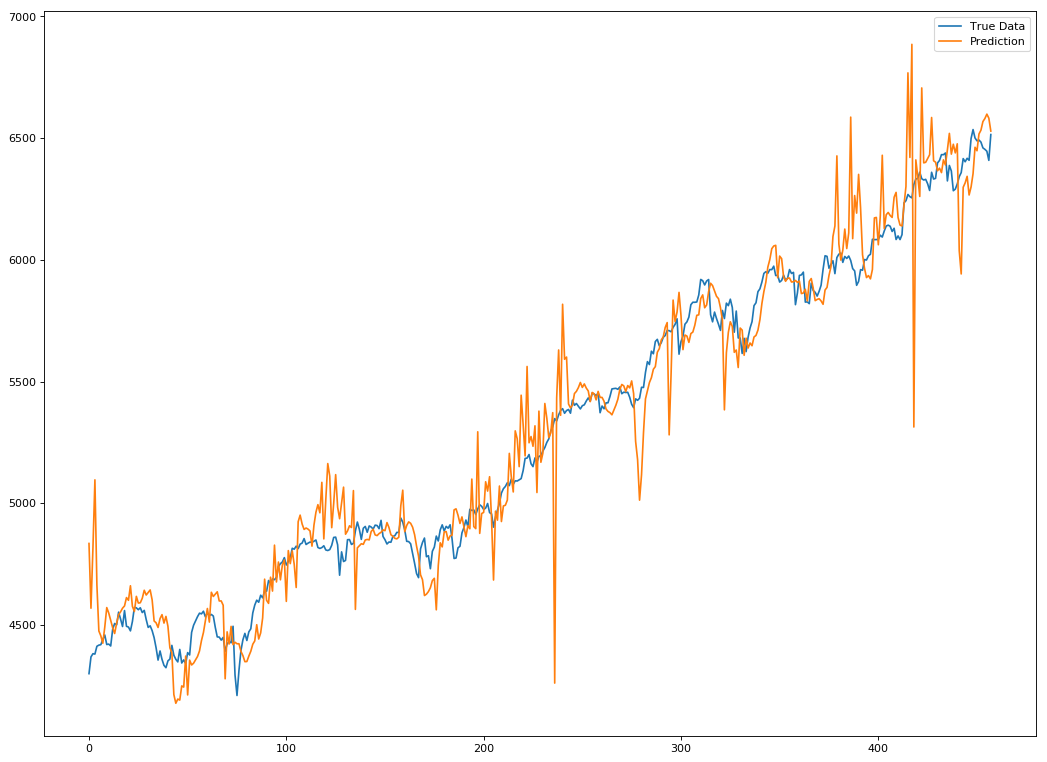

MDA: 
Train: ~0.9
Test: 0.5021834061135371
Three Categories:0.4978165938864629
MAPE: 2.0657267167829256


In [21]:
y_test = denormalize(y_test)
value_model = load_model('value_model.h5', custom_objects=dependencies)
value_predictions = predict(value_model, X_test)
value_predictions = denormalize(value_predictions)
plot_results(value_predictions, y_test)

print("MDA: ")
print("Train: ~0.9")
print("Test: " + str(meanDirectionalAccuracy(value_predictions, y_test)))

print("Three Categories:" + str(threeCategories(value_predictions, y_test, 1)))

print("MAPE: " + str(mape(value_predictions, y_test)))

# Directional Results

In [15]:
def accuracy(predicted_data, true_data):
    score = 0
    for i in range(len(predicted_data)):
        if np.argmax(predicted_data[i]) == np.argmax(true_data[i]):
            score = score+1
    return 1/len(predicted_data)*score

In [16]:
model = load_model('mcfly_model.h5', custom_objects=dependencies)
predictions = predict(model, X_test)
predictions = np.reshape(predictions,direction_data.shape)

print("Accuracy: ")
print("Test: " + str(accuracy(predictions, direction_data)))

OSError: Unable to open file (unable to open file: name = 'mcfly_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)